In [1]:
import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT
from IPython.display import Image, display

import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

tf.__version__
artmodel = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
artmodel.summary()

from collections import OrderedDict
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 134)               3361792   
                                                                 
 lambda (Lambda)             (None, 134)               0         
                                                                 
Total params: 18,076,480
Trainable params: 3,361,792
Non-trainable params: 14,714,688
_________________________________________________________________


In [2]:
def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()
    canvas_size=2280
    mag_ratio=1.5
    show_time=False
    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    if show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text


In [3]:
import h5py
def getlabel(img):
    # img = image.load_img('r1.png', target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    predictions=artmodel.predict(img_preprocessed)
    predicted_labels = np.argmax(predictions, axis=1)
    i=predicted_labels[0]
    print(i)
    labels=""
    with h5py.File('test.hdf5', 'r') as f:
        labels = f['default']
        a=labels[i]
    return a

In [4]:
from PIL import Image as Img
from PIL import ImageDraw
from PIL import ImageFont
myFont = ImageFont.truetype('Lato-Bold.ttf', 15)

In [5]:
def craft(tf1):
    net = CRAFT()     # initialize
    trained_model='weights/craft_mlt_25k.pth'
    text_threshold=0.7
    low_text=0.5
    link_threshold=.9
    cuda=False
    canvas_size=1280
    
    poly=False
    
#     test_folder='/data/'
    refine=False
    refiner_model='weights/craft_refiner_CTW1500.pth'
    
    result_folder = './result/'
    if not os.path.isdir(result_folder):
        os.mkdir(result_folder)
    print(tf1)
    image_list, _, _ = file_utils.get_files(tf1)
    if(image_list==[]):
        image_list=[tf1]
    print('Loading weights from checkpoint (' + trained_model + ')')
    if cuda:
        net.load_state_dict(copyStateDict(torch.load(trained_model)))
    else:
        net.load_state_dict(copyStateDict(torch.load(trained_model, map_location='cpu')))

    if cuda:
        net = net.cuda()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = False

    net.eval()

    # LinkRefiner
    refine_net = None
    if refine:
        from refinenet import RefineNet
        refine_net = RefineNet()
        print('Loading weights of refiner from checkpoint (' + refiner_model + ')')
        if cuda:
            refine_net.load_state_dict(copyStateDict(torch.load(refiner_model)))
            refine_net = refine_net.cuda()
            refine_net = torch.nn.DataParallel(refine_net)
        else:
            refine_net.load_state_dict(copyStateDict(torch.load(refiner_model, map_location='cpu')))

        refine_net.eval()
        poly = True

    t = time.time()

    # load data
    for k, image_path in enumerate(image_list):
        print(image_path)
        print("Test image {:d}/{:d}: {:s}".format(k+1, len(image_list), image_path), end='\r')
        image = imgproc.loadImage(image_path)

        bboxes, polys, score_text = test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net)
#         print(polys)
        # save score text
        filename, file_ext = os.path.splitext(os.path.basename(image_path))
        mask_file = result_folder + "/res_" + filename + '_mask.jpg'
        cv2.imwrite(mask_file, score_text)
    
        file_utils.saveResult(image_path, image[:,:,::-1], polys, dirname=result_folder)
        f1 = result_folder + "/res_" + filename + '.jpg'
        img=cv2.imread(image_path)
        final=Img.open(f1)
        I1 = ImageDraw.Draw(final)
        for pts in polys:
            rect = cv2.boundingRect(pts)
            x,y,w,h = rect
            croped = img[y:y+h, x:x+w].copy()
            display(Img.fromarray(croped[:,:,::-1]))
            c=cv2.resize(croped,(224,224))
            label=getlabel(c)
            print(label)
            
            I1.text((x, y-10), str(label),font=myFont,fill=(0,255, 0))
    
    display(final)
    final.show()
    print("elapsed time : {}s".format(time.time() - t))


C:\ProgramData\Anaconda3\envs\craft_model\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\craft_model\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\craft_model\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


images/img.png
Loading weights from checkpoint (weights/craft_mlt_25k.pth)
images/img.png


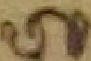

1/1 [==============================] - 3s 3s/step
54
b'GUWUNG-MACELEK'


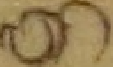

1/1 [==============================] - 1s 1s/step
54
b'GUWUNG-MACELEK'


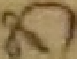

1/1 [==============================] - 1s 1s/step
123
b'ULU-RICEM'


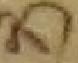

1/1 [==============================] - 1s 1s/step
92
b'PAMADA'


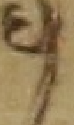

1/1 [==============================] - 1s 1s/step
54
b'GUWUNG-MACELEK'


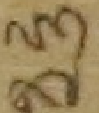

1/1 [==============================] - 1s 1s/step
92
b'PAMADA'


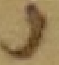

1/1 [==============================] - 2s 2s/step
54
b'GUWUNG-MACELEK'


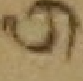

1/1 [==============================] - 2s 2s/step
92
b'PAMADA'


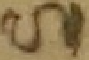

1/1 [==============================] - 1s 1s/step
23
b'CU'


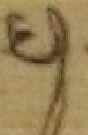

1/1 [==============================] - 1s 1s/step
54
b'GUWUNG-MACELEK'


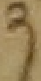

1/1 [==============================] - 1s 1s/step
54
b'GUWUNG-MACELEK'


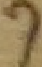

1/1 [==============================] - 1s 1s/step
18
b'BISAH'


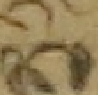

1/1 [==============================] - 1s 1s/step
92
b'PAMADA'


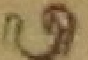

1/1 [==============================] - 1s 1s/step
123
b'ULU-RICEM'


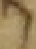

1/1 [==============================] - 2s 2s/step
18
b'BISAH'


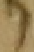

1/1 [==============================] - 3s 3s/step
18
b'BISAH'


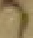

1/1 [==============================] - 6s 6s/step
18
b'BISAH'


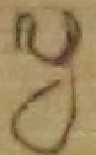

1/1 [==============================] - 2s 2s/step
23
b'CU'


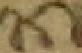

1/1 [==============================] - 2s 2s/step
17
b'BI'


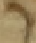

1/1 [==============================] - 2s 2s/step
18
b'BISAH'


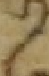

1/1 [==============================] - 1s 1s/step
14
b'ADEG-ADEG'


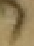

1/1 [==============================] - 2s 2s/step
18
b'BISAH'


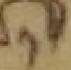

1/1 [==============================] - 2s 2s/step
23
b'CU'


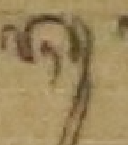

1/1 [==============================] - 1s 1s/step
92
b'PAMADA'


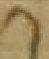

1/1 [==============================] - 1s 1s/step
18
b'BISAH'


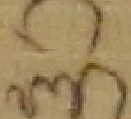

1/1 [==============================] - 1s 1s/step
92
b'PAMADA'


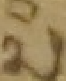

1/1 [==============================] - 2s 2s/step
14
b'ADEG-ADEG'


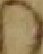

1/1 [==============================] - 2s 2s/step
14
b'ADEG-ADEG'


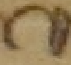

1/1 [==============================] - 1s 1s/step
18
b'BISAH'


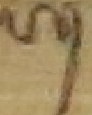

1/1 [==============================] - 1s 1s/step
92
b'PAMADA'


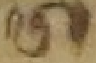

1/1 [==============================] - 1s 1s/step
92
b'PAMADA'


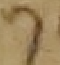

1/1 [==============================] - 1s 1s/step
18
b'BISAH'


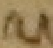

1/1 [==============================] - 1s 1s/step
111
b'TA-TEDONG'


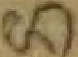

1/1 [==============================] - 2s 2s/step
123
b'ULU-RICEM'


1/1 [==============================] - 1s 1s/step
18
b'BISAH'


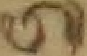

1/1 [==============================] - 1s 1s/step
54
b'GUWUNG-MACELEK'


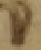

1/1 [==============================] - 1s 1s/step
54
b'GUWUNG-MACELEK'


1/1 [==============================] - 1s 1s/step
18
b'BISAH'


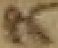

1/1 [==============================] - 1s 1s/step
18
b'BISAH'


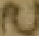

1/1 [==============================] - 1s 1s/step
54
b'GUWUNG-MACELEK'


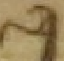

1/1 [==============================] - 1s 1s/step
17
b'BI'


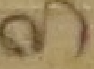

1/1 [==============================] - 1s 1s/step
14
b'ADEG-ADEG'


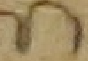

1/1 [==============================] - 1s 1s/step
123
b'ULU-RICEM'


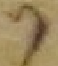

1/1 [==============================] - 1s 1s/step
14
b'ADEG-ADEG'


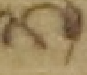

1/1 [==============================] - 1s 1s/step
23
b'CU'


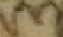

1/1 [==============================] - 1s 1s/step
54
b'GUWUNG-MACELEK'


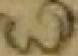

1/1 [==============================] - 1s 1s/step
92
b'PAMADA'


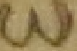

1/1 [==============================] - 1s 1s/step
54
b'GUWUNG-MACELEK'


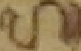

1/1 [==============================] - 1s 1s/step
54
b'GUWUNG-MACELEK'


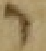

1/1 [==============================] - 1s 1s/step
18
b'BISAH'


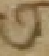

1/1 [==============================] - 1s 1s/step
54
b'GUWUNG-MACELEK'


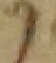

1/1 [==============================] - 1s 1s/step
14
b'ADEG-ADEG'


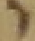

1/1 [==============================] - 1s 1s/step
18
b'BISAH'


1/1 [==============================] - 1s 1s/step
18
b'BISAH'


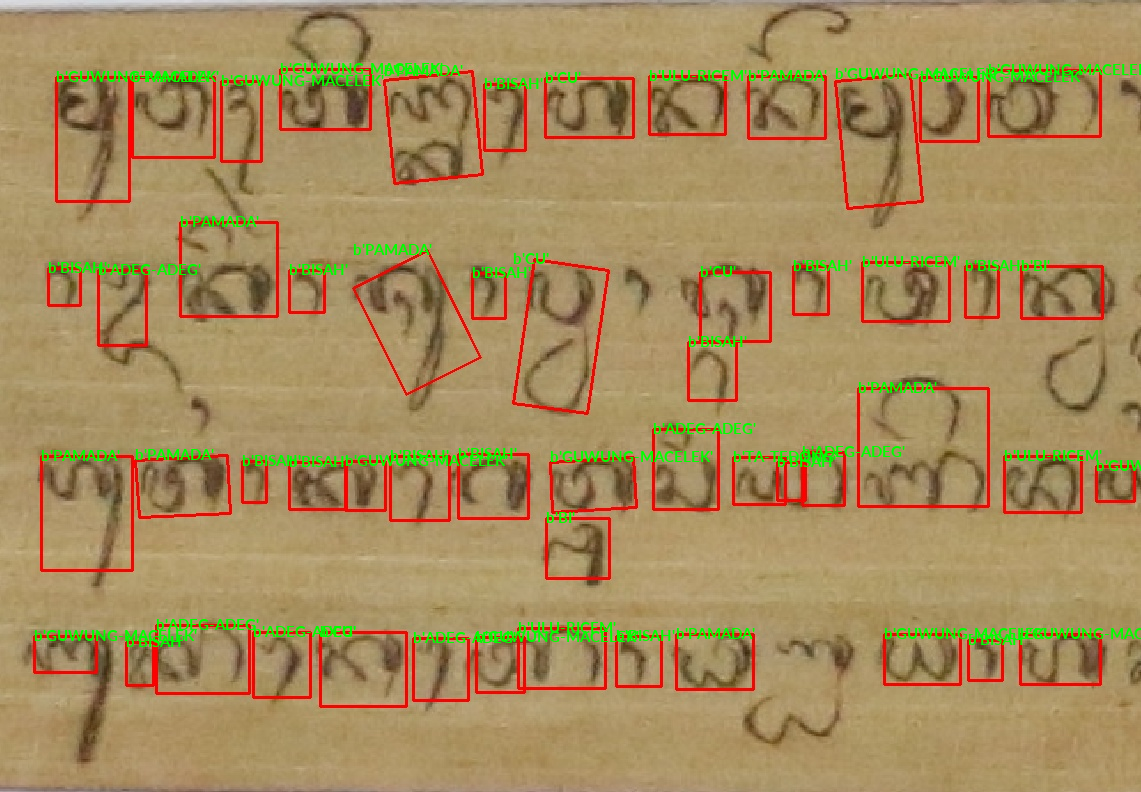

elapsed time : 190.80354690551758s


In [6]:
craft('images/img.png')